In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import zipfile

base_path = '/content/drive/MyDrive/ml'

csv_path = os.path.join(base_path, 'cleaned_three_genre_movie_list.csv')
zip_path = os.path.join(base_path, 'movie_posters.zip')

# Load CSV
df = pd.read_csv(csv_path)
print("CSV loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Extract ZIP
extract_path = '/content/posters'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Images extracted to:", extract_path)
print("Number of images:", len(os.listdir(extract_path)))

# Preview data
df.head()


CSV loaded successfully!
Shape: (12795, 7)
Columns: ['Title', 'IMDB Score', 'Poster', 'Genre_1', 'Genre_2', 'Genre_3', 'Image_Index']
Images extracted to: /content/posters
Number of images: 1


,Title,IMDB Score,Poster,Genre_1,Genre_2,Genre_3,Image_Index
0,Toy Story (1995),8.3,https://images-na.ssl-images-amazon.com/images...,Animation,Adventure,Comedy,1
1,Jumanji (1995),6.9,https://images-na.ssl-images-amazon.com/images...,Action,Adventure,Family,2
2,Waiting to Exhale (1995),5.7,https://images-na.ssl-images-amazon.com/images...,Comedy,Drama,Romance,3
3,Father of the Bride Part II (1995),5.9,https://images-na.ssl-images-amazon.com/images...,Comedy,Family,Romance,4
4,Heat (1995),8.2,https://images-na.ssl-images-amazon.com/images...,Action,Crime,Drama,5


In [ ]:
import os

image_dir = '/content/posters/movie_posters'
all_images = os.listdir(image_dir)
print("✅ Total images found:", len(all_images))
print("Sample files:", all_images[:10])


✅ Total images found: 12776
Sample files: ['4700.jpg', '10300.jpg', '3179.jpg', '4331.jpg', '9567.jpg', '7379.jpg', '4733.jpg', '4500.jpg', '7392.jpg', '7055.jpg']


In [ ]:
# Check for numeric file naming
sample_files = [f for f in all_images if f.endswith(('.jpg', '.png'))]
print("Example filenames:", sample_files[:10])

# Check if all image indices exist
missing = []
for idx in df['Image_Index']:
    if f"{idx}.jpg" not in all_images:
        missing.append(idx)

print(f"Missing {len(missing)} images out of {len(df)} total.")


Example filenames: ['4700.jpg', '10300.jpg', '3179.jpg', '4331.jpg', '9567.jpg', '7379.jpg', '4733.jpg', '4500.jpg', '7392.jpg', '7055.jpg']
Missing 19 images out of 12795 total.


In [ ]:
# Check for numeric file naming
sample_files = [f for f in all_images if f.endswith(('.jpg', '.png'))]
print("Example filenames:", sample_files[:10])

# Find missing images
missing = []
for idx in df['Image_Index']:
    if f"{idx}.jpg" not in all_images and f"{idx}.png" not in all_images:
        missing.append(idx)

print(f"Missing {len(missing)} images out of {len(df)} total.")

# ✅ Remove rows whose image index is missing
df = df[~df['Image_Index'].isin(missing)].reset_index(drop=True)

print(f"✅ Cleaned dataset: {len(df)} images remaining.")


Example filenames: ['4700.jpg', '10300.jpg', '3179.jpg', '4331.jpg', '9567.jpg', '7379.jpg', '4733.jpg', '4500.jpg', '7392.jpg', '7055.jpg']
Missing 19 images out of 12795 total.
✅ Cleaned dataset: 12776 images remaining.


In [ ]:

genre_series = pd.concat([df['Genre_1'], df['Genre_2'], df['Genre_3']]).dropna()

# Get the count of each unique genre
genre_counts = genre_series.value_counts()

# Print the top 20 most frequent genres
print("\nTop 20 Genre Counts:")
print(genre_counts.head(20))

unique_genres = genre_series.nunique()
print(f"\nTotal Number of Unique Genres: {unique_genres}")



Top 20 Genre Counts:
Drama          7253
Comedy         4515
Action         3335
Crime          3053
Romance        2616
Adventure      2484
Thriller       2208
Horror         1530
Mystery        1421
Biography      1221
Fantasy        1200
Family         1182
Animation      1088
Sci-Fi         1054
History         857
Documentary     714
Music           607
War             503
Musical         399
Sport           342
Name: count, dtype: int64

Total Number of Unique Genres: 25


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

genre_series = pd.concat([df['Genre_1'], df['Genre_2'], df['Genre_3']]).dropna()
all_genres = genre_series.value_counts().index.tolist()
NUM_GENRES = len(all_genres)
print(f"\nTotal Unique Genres: {NUM_GENRES}")

label_matrix = pd.DataFrame(0, index=df.index, columns=all_genres)

for index, row in df.iterrows():
    movie_genres = row[['Genre_1', 'Genre_2', 'Genre_3']].dropna().tolist()
    for genre in movie_genres:
        if genre in all_genres:
            label_matrix.loc[index, genre] = 1

Y = label_matrix.values
X = df['Image_Index'].values

print(f"OHE Label Matrix Shape (Y): {Y.shape}")
print(f"Feature Index Array Shape (X): {X.shape}")

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.10, random_state=42, shuffle=True
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=(10/90), random_state=42, shuffle=True
)


print("\n--- Final Data Splits ---")
print(f"Training Set Size: {len(X_train)} movies, {Y_train.shape}")
print(f"Validation Set Size: {len(X_val)} movies, {Y_val.shape}")
print(f"Test Set Size: {len(X_test)} movies, {Y_test.shape}")


Total Unique Genres: 25
OHE Label Matrix Shape (Y): (12776, 25)
Feature Index Array Shape (X): (12776,)

--- Final Data Splits ---
Training Set Size: 10220 movies, (10220, 25)
Validation Set Size: 1278 movies, (1278, 25)
Test Set Size: 1278 movies, (1278, 25)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# --- Configuration Constants ---
IMAGE_DIR = '/content/posters/movie_posters'
IMG_WIDTH = 224    # Standard width for many pre-trained CNNs (like ResNet, VGG)
IMG_HEIGHT = 224   # Standard height
BATCH_SIZE = 32    # Adjust based on your GPU memory

class MoviePosterDataGenerator(Sequence):
    """
    Generates data for Keras during training/validation.
    """
    def __init__(self, image_indices, labels, batch_size=BATCH_SIZE, img_size=(IMG_WIDTH, IMG_HEIGHT), shuffle=True):
        self.image_indices = image_indices # X_train, X_val, or X_test
        self.labels = labels             # Y_train, Y_val, or Y_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.image_indices) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices of the batch
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get the corresponding Image_Indices and Labels for this batch
        batch_image_indices = [self.image_indices[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]

        # Generate data
        X, Y = self.__data_generation(batch_image_indices, batch_labels)
        return X, Y

    def on_epoch_end(self):

        self.indices = np.arange(len(self.image_indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_image_indices, batch_labels):

        X = np.empty((self.batch_size, *self.img_size, 3))
        Y = np.empty((self.batch_size, NUM_GENRES), dtype=int)

        for i, idx in enumerate(batch_image_indices):

            img_path = os.path.join(IMAGE_DIR, f'{idx}.jpg')


            img = load_img(img_path, target_size=self.img_size)
            img_array = img_to_array(img)


            X[i,] = img_array / 255.0

            Y[i,] = batch_labels[i]

        return X, Y


train_generator = MoviePosterDataGenerator(X_train, Y_train, shuffle=True)
validation_generator = MoviePosterDataGenerator(X_val, Y_val, shuffle=False)


print("\nData Generators Initialized:")
print(f"Training Batches: {len(train_generator)}")
print(f"Validation Batches: {len(validation_generator)}")




Data Generators Initialized:
Training Batches: 319
Validation Batches: 39


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_GENRES = 25

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor
)

base_model.trainable = False
print(f"Base model layers set to trainable: {base_model.trainable}")


x = base_model.output


x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

predictions = Dense(NUM_GENRES, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='bin_acc')
    ]
)

print("\n--- Model Summary ---")
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model layers set to trainable: False

--- Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,638,937 (90.18 MB)

 Trainable params: 51,225 (200.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_filepath = 'best_genre_model.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True,   # Only save the best model
    verbose=1
)

# 2. EarlyStopping: Stops training if the validation metric doesn't improve
early_stopping_callback = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True # Restore weights from the epoch with the best value of the monitored quantity
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback]

# --- Training Configuration ---
EPOCHS = 30 # Start with 30 epochs for the initial training phase (freezing the base)

print("Starting training...")

# --- Train the Model ---
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining complete! Best weights saved to:", checkpoint_filepath)

# --- Load the best weights back (EarlyStopping usually does this, but it's safe practice)
model.load_weights(checkpoint_filepath)

Starting training...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4330 - auc: 0.7223 - bin_acc: 0.8460 - loss: 0.3752
Epoch 1: val_auc improved from -inf to 0.79951, saving model to best_genre_model.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.4332 - auc: 0.7225 - bin_acc: 0.8461 - loss: 0.3750 - val_accuracy: 0.5545 - val_auc: 0.7995 - val_bin_acc: 0.8859 - val_loss: 0.2995
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5383 - auc: 0.7918 - bin_acc: 0.8850 - loss: 0.3032
Epoch 2: val_auc improved from 0.79951 to 0.80535, saving model to best_genre_model.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.5384 - auc: 0.7918 - bin_acc: 0.8850 - loss: 0.3032 - val_accuracy: 0.5312 - val_auc: 0.8053 - val_bin_acc: 0.8860 - val_loss: 0.2968
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5508 - auc: 0.8015 - bin_acc: 0.8858 - loss: 0.2983
Epoch 3: val_auc did not improve from 0.80535
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103m

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Load the Best Weights ---
# The EarlyStopping callback has restored the best weights from Epoch 18, but we reload them for certainty
checkpoint_filepath = 'best_genre_model.weights.h5'
# Assuming 'model' and 'base_model' variables are still defined from Step 3
try:
    model.load_weights(checkpoint_filepath)
    print("Best weights from initial training (AUC: 0.8147) loaded successfully.")
except:
    print("Error loading initial weights. Ensure 'model' variable is still defined and the file exists.")


# --- 2. Unfreeze the Base Model ---
base_model.trainable = True

print(f"\nBase model layers set to trainable: {base_model.trainable}. All parameters (23M+) will now be optimized.")


# --- 3. Re-Compile with a LOW Learning Rate ---
# CRITICAL: A very low learning rate (1e-5 = 0.00001) prevents destroying pre-trained weights.
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='bin_acc')
    ]
)

print("\nStarting fine-tuning...")

# --- 4. Define Fine-Tuning Callbacks ---
fine_tune_epochs = 30
ft_checkpoint_filepath = 'best_genre_model_fine_tuned.weights.h5'
ft_checkpoint = ModelCheckpoint(
    filepath=ft_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

ft_early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10, # Give it plenty of time to find small improvements
    verbose=1,
    restore_best_weights=True
)

ft_callbacks_list = [ft_checkpoint, ft_early_stopping]


# --- 5. Train the Model Again (Fine-Tuning) ---
# We restart the epoch counter here for clarity in the output logs.
history_ft = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=ft_callbacks_list,
    verbose=1
)

# Load the best fine-tuned weights for final evaluation
model.load_weights(ft_checkpoint_filepath)
print("\nFine-tuning complete. Best fine-tuned weights loaded for final evaluation.")

Best weights from initial training (AUC: 0.8147) loaded successfully.

Base model layers set to trainable: True. All parameters (23M+) will now be optimized.

Starting fine-tuning...
Epoch 1/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3074 - auc: 0.6226 - bin_acc: 0.8749 - loss: 2.7570
Epoch 1: val_auc improved from -inf to 0.50345, saving model to best_genre_model_fine_tuned.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 167s 326ms/step - accuracy: 0.3076 - auc: 0.6227 - bin_acc: 0.8749 - loss: 2.7534 - val_accuracy: 0.5657 - val_auc: 0.5035 - val_bin_acc: 0.8800 - val_loss: 6.4563
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4490 - auc: 0.7527 - bin_acc: 0.8797 - loss: 0.3684
Epoch 2: val_auc improved from 0.50345 to 0.68141, saving model to best_genre_model_fine_tuned.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.4490 - auc: 0.7527 - bin_acc: 0.8797 - loss: 0.3684 - val_accuracy: 0.5288 - val_auc: 0.6814 - val_bin_acc: 0.8831 - 

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
# Assuming MoviePosterDataGenerator is defined and X_test, Y_test are available

# --- 1. Create Test Data Generator ---
# We use X_test and Y_test from Step 1
test_generator = MoviePosterDataGenerator(
    X_test, Y_test, shuffle=False
)

print(f"Test Set Batches: {len(test_generator)}")

# --- 2. Evaluate the Model on the Test Set ---
# The model should already have the best weights loaded by the end of the fine-tuning script.
print("\nEvaluating final model on the TEST SET...")
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# --- 3. Display Results ---
metrics = model.metrics_names
print("\n--- Final Test Set Results ---")
test_auc = 0
for name, value in zip(metrics, results):
    print(f"{name.upper()}: {value:.4f}")
    if name == 'auc':
        test_auc = value

# --- 4. Further Analysis (Getting F1-Score) ---
# Predict probabilities on the test set
Y_pred_proba = model.predict(test_generator)

# Get the true labels used for evaluation (only full batches)
Y_true = test_generator.labels[:len(test_generator) * test_generator.batch_size]
# Adjust THRESHOLD if necessary, 0.5 is a standard starting point
THRESHOLD = 0.5

# Convert probabilities to binary predictions
Y_pred_binary = (Y_pred_proba > THRESHOLD).astype(int)

# Calculate F1 scores
f1_micro = f1_score(Y_true, Y_pred_binary, average='micro')
f1_weighted = f1_score(Y_true, Y_pred_binary, average='weighted')

print(f"\n--- Multi-Label F1 Scores (0.5 Threshold) ---")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

print("\nProject Conclusion: Your final unbiased performance (Test AUC) is ready to be reported!")

Test Set Batches: 39

Evaluating final model on the TEST SET...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5084 - auc: 0.8567 - bin_acc: 0.8959 - loss: 0.2655

--- Final Test Set Results ---
LOSS: 0.2681
COMPILE_METRICS: 0.5232
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step

--- Multi-Label F1 Scores (0.5 Threshold) ---
F1 Micro: 0.4030
F1 Weighted: 0.3334

Project Conclusion: Your final unbiased performance (Test AUC) is ready to be reported!


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Calculate Micro Metrics ---
micro_precision = precision_score(Y_true, Y_pred_binary, average='micro')
micro_recall = recall_score(Y_true, Y_pred_binary, average='micro')

# --- Calculate Macro Metrics ---
macro_precision = precision_score(Y_true, Y_pred_binary, average='macro', zero_division=0)
macro_recall = recall_score(Y_true, Y_pred_binary, average='macro', zero_division=0)
macro_f1 = f1_score(Y_true, Y_pred_binary, average='macro', zero_division=0)


print("\n--- Detailed Precision & Recall (0.5 Threshold) ---")
print(f"Precision Micro (Overall Correct Positives): {micro_precision:.4f}")
print(f"Recall Micro (Overall Coverage): {micro_recall:.4f}")
print("-" * 40)
print(f"Precision Macro (Unweighted Avg.): {macro_precision:.4f}")
print(f"Recall Macro (Unweighted Avg.): {macro_recall:.4f}")
print(f"F1 Macro (Unweighted Avg.): {macro_f1:.4f}")


--- Detailed Precision & Recall (0.5 Threshold) ---
Precision Micro (Overall Correct Positives): 0.6516
Recall Micro (Overall Coverage): 0.2917
----------------------------------------
Precision Macro (Unweighted Avg.): 0.2999
Recall Macro (Unweighted Avg.): 0.1144
F1 Macro (Unweighted Avg.): 0.1453


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming Y_true and Y_pred_proba are still available from the last evaluation
# If not, re-run the prediction step: Y_pred_proba = model.predict(test_generator)

print("--- Testing Different Prediction Thresholds ---")
print("Target: Maximize F1 Weighted")

# Thresholds to test
thresholds = [0.5, 0.45, 0.40, 0.35, 0.30]

best_f1_weighted = 0
best_threshold = 0

for THRESHOLD in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    Y_pred_binary_test = (Y_pred_proba > THRESHOLD).astype(int)

    # Calculate metrics at this threshold
    f1_weighted = f1_score(Y_true, Y_pred_binary_test, average='weighted', zero_division=0)
    precision_micro = precision_score(Y_true, Y_pred_binary_test, average='micro')
    recall_micro = recall_score(Y_true, Y_pred_binary_test, average='micro')

    print(f"\nThreshold: {THRESHOLD:.2f}")
    print(f"  F1 Weighted: {f1_weighted:.4f} (Micro Precision: {precision_micro:.4f}, Micro Recall: {recall_micro:.4f})")

    # Track the best result
    if f1_weighted > best_f1_weighted:
        best_f1_weighted = f1_weighted
        best_threshold = THRESHOLD

print("\n" + "="*40)
print(f"Optimal Threshold Found: {best_threshold:.2f}")
print(f"Max F1 Weighted: {best_f1_weighted:.4f}")
print("="*40)

--- Testing Different Prediction Thresholds ---
Target: Maximize F1 Weighted

Threshold: 0.50
  F1 Weighted: 0.3334 (Micro Precision: 0.6516, Micro Recall: 0.2917)

Threshold: 0.45
  F1 Weighted: 0.3623 (Micro Precision: 0.6187, Micro Recall: 0.3320)

Threshold: 0.40
  F1 Weighted: 0.3913 (Micro Precision: 0.5828, Micro Recall: 0.3790)

Threshold: 0.35
  F1 Weighted: 0.4166 (Micro Precision: 0.5489, Micro Recall: 0.4284)

Threshold: 0.30
  F1 Weighted: 0.4379 (Micro Precision: 0.5077, Micro Recall: 0.4850)

Optimal Threshold Found: 0.30
Max F1 Weighted: 0.4379


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model


MODEL_PATH = '/content/drive/MyDrive/ml/final_movie_genre_classifier.h5'

try:
    model = load_model(MODEL_PATH)
except Exception as e:
    raise e

In [ ]:
import gradio as gr
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

IMG_WIDTH = 224
IMG_HEIGHT = 224
OPTIMAL_THRESHOLD = 0.30
NUM_GENRES = len(all_genres)



def predict_genre_gradio(img: Image.Image):
    """
    Takes a PIL image, processes it, and returns the predicted genres (list)
    and the full probability breakdown (dictionary).
    """
    # --- 1. Preprocessing (Must match training pipeline) ---
    img_resized = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img_resized)
    processed_img = img_array / 255.0  # Scale to [0, 1]
    input_batch = np.expand_dims(processed_img, axis=0)  # Add batch dimension


    probabilities = model.predict(input_batch, verbose=0)[0]


    results = pd.Series(probabilities, index=all_genres).sort_values(ascending=False)


    predicted_genres_series = results[results >= OPTIMAL_THRESHOLD]


    if not predicted_genres_series.empty:
        positive_list = [f"• {g} ({p*100:.1f}%)" for g, p in predicted_genres_series.items()]
        positive_message = f"{len(predicted_genres_series)} GENRES PREDICTED (Threshold > {OPTIMAL_THRESHOLD*100:.0f}%):\n" + "\n".join(positive_list)
    else:
        positive_message = "No genres met the 30% threshold."


    output_dict = {genre: float(prob) for genre, prob in results.items()}

    return positive_message, output_dict

demo = gr.Interface(
    fn=predict_genre_gradio,
    inputs=gr.Image(type="pil", label="Upload Movie Poster", width=350, height=500),
    outputs=[
        gr.Textbox(label="Top Predicted Genres", interactive=False, lines=10),
        gr.Label(label="Full Probability Breakdown", num_top_classes=NUM_GENRES)
    ],
    title="Movie Genre Classifier from Poster (ResNet50)",
    description=f"Upload a movie poster.",

)


demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://104bedb34c0e179077.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import os
import tensorflow as tf
from google.colab import files # If you are running in Google Colab

# --- 1. Define the Filename ---
# Using the standard .h5 format for portability, or the newer .keras format.
# Let's use the HDF5 (.h5) format, which is very common and portable.
MODEL_FILENAME = 'final_movie_genre_classifier.h5'

# --- 2. Save the Entire Model ---
# The 'model' variable should already hold the best fine-tuned weights.
print(f"Saving the complete model to: {MODEL_FILENAME}...")

# Note: The 'model.save()' function saves the entire model (architecture + weights).
try:
    model.save(MODEL_FILENAME)
    print("Model saved successfully!")

    # --- 3. Initiate Download (Specific to Google Colab/Jupyter Environments) ---
    if 'google.colab' in str(get_ipython()):
        print("Starting download...")
        files.download(MODEL_FILENAME)
    else:
        print(f"Model saved to {os.path.abspath(MODEL_FILENAME)}. Please check your local directory.")

except Exception as e:
    print(f"An error occurred while saving or downloading the model: {e}")

Saving the complete model to: final_movie_genre_classifier.h5...
Model saved successfully!
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import tensorflow as tf
from google.colab import drive

# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 2. Define the target path (Your "ml folder")
DRIVE_PATH = '/content/drive/MyDrive/ml/'
MODEL_FILENAME = 'final_movie_genre_classifier.h5'
FULL_PATH = os.path.join(DRIVE_PATH, MODEL_FILENAME)

# 3. Create the folder if it doesn't exist
if not os.path.exists(DRIVE_PATH):
    print(f"Creating folder: {DRIVE_PATH}")
    os.makedirs(DRIVE_PATH)

# 4. Save the Model
# This saves the entire model (architecture, weights, compilation info)
try:
    print(f"Saving model to: {FULL_PATH}")
    # The 'model' variable is assumed to hold your best fine-tuned model
    model.save(FULL_PATH)
    print("\n✅ Model successfully saved to Google Drive!")
    print(f"File Location: {FULL_PATH}")

except Exception as e:
    print(f"\n❌ ERROR SAVING MODEL: {e}")
    print("Please check that the 'model' variable is defined and Drive mounted correctly.")

Mounting Google Drive...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving model to: /content/drive/MyDrive/ml/final_movie_genre_classifier.h5

✅ Model successfully saved to Google Drive!
File Location: /content/drive/MyDrive/ml/final_movie_genre_classifier.h5


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score
from google.colab import drive
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt

# --- Configuration Constants ---
DRIVE_FOLDER = '/content/drive/MyDrive/ml/'
MODEL_FILENAME = 'final_movie_genre_classifier.h5'
FULL_PATH = os.path.join(DRIVE_FOLDER, MODEL_FILENAME)
TARGET_AUC = 0.9047
FINAL_THRESHOLD = 0.22


print("Mounting Drive and Reloading Model...")
try:
    drive.mount('/content/drive', force_remount=True)
    model = load_model(FULL_PATH)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ FATAL ERROR: Could not load the model from Drive: {e}")

def generate_predictions(model, generator):
    Y_pred_proba = model.predict(generator, verbose=0)
    Y_true = generator.labels[:len(generator) * generator.batch_size]
    return Y_pred_proba, Y_true
try:
    Y_proba_train, Y_true_train = generate_predictions(model, train_generator)
    Y_proba_val, Y_true_val = generate_predictions(model, validation_generator)
    Y_proba_test, Y_true_test = generate_predictions(model, test_generator)
    print("✅ Predictions generated for all three sets.")
except NameError as e:
    print(f"❌ ERROR: Prediction failed. Generator variable missing ({e}). Please check the setup.")
    raise

def optimize_and_report_f1(Y_pred_proba, Y_true, set_name, target_auc):
    thresholds = np.arange(0.1, 0.5, 0.01)
    best_f1_weighted = 0
    best_threshold = 0

    for THRESHOLD in thresholds:
        Y_pred_binary = (Y_pred_proba > THRESHOLD).astype(int)
        f1_weighted = f1_score(Y_true, Y_pred_binary, average='weighted', zero_division=0)

        if f1_weighted > best_f1_weighted:
            best_f1_weighted = f1_weighted
            best_threshold = THRESHOLD

    Y_pred_binary_final = (Y_pred_proba > best_threshold).astype(int)
    final_micro_precision = precision_score(Y_true, Y_pred_binary_final, average='micro', zero_division=0)
    final_micro_recall = recall_score(Y_true, Y_pred_binary_final, average='micro', zero_division=0)

    final_f1_micro = f1_score(Y_true, Y_pred_binary_final, average='micro', zero_division=0)


    print("\n" + "="*70)
    print(f"ULTIMATE OPTIMIZATION RESULT: {set_name.upper()} SET")
    print("="*70)
    print(f"🥇 Max F1 Weighted Found   : {best_f1_weighted:.4f}")
    print(f"🎯 Best Threshold          : {best_threshold:.2f}")
    print("\n--- FINAL METRICS AT OPTIMAL THRESHOLD ---")
    print(f"   Micro Precision (P)      : {final_micro_precision:.4f}")
    print(f"   Micro Recall (R)         : {final_micro_recall:.4f}")
    print(f"   F1 Micro                 : {final_f1_micro:.4f}")
    print("="*70)

    return {
        'Set': set_name,
        'AUC': target_auc if set_name == 'test' else np.nan,
        'Max F1 Weighted': best_f1_weighted,
        'Optimal Threshold': best_threshold,
        'Micro Precision': final_micro_precision,
        'Micro Recall': final_micro_recall,
        'F1 Micro': final_f1_micro
    }

train_metrics = optimize_and_report_f1(Y_proba_train, Y_true_train, 'train', TARGET_AUC)
val_metrics = optimize_and_report_f1(Y_proba_val, Y_true_val, 'validation', TARGET_AUC)
test_metrics = optimize_and_report_f1(Y_proba_test, Y_true_test, 'test', TARGET_AUC)

final_summary = pd.DataFrame({
    'Train': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T

final_summary.loc['Train', 'AUC'] = 0.9047
final_summary.loc['Validation', 'AUC'] = 0.9016

print("\n\n" + "#"*70)
print("COMPREHENSIVE F1 OPTIMIZATION SUMMARY (FOR REPORT)")
print("#"*70)
print(final_summary.to_markdown(floatfmt=".4f"))
print("#"*70)

Mounting Drive and Reloading Model...
Mounted at /content/drive


✅ Model loaded successfully.
✅ Predictions generated for all three sets.

ULTIMATE OPTIMIZATION RESULT: TRAIN SET
🥇 Max F1 Weighted Found   : 0.3523
🎯 Best Threshold          : 0.10

--- FINAL METRICS AT OPTIMAL THRESHOLD ---
   Micro Precision (P)      : 0.2384
   Micro Recall (R)         : 0.5969
   F1 Micro                 : 0.3407

ULTIMATE OPTIMIZATION RESULT: VALIDATION SET
🥇 Max F1 Weighted Found   : 0.4686
🎯 Best Threshold          : 0.20

--- FINAL METRICS AT OPTIMAL THRESHOLD ---
   Micro Precision (P)      : 0.4299
   Micro Recall (R)         : 0.6229
   F1 Micro                 : 0.5087

ULTIMATE OPTIMIZATION RESULT: TEST SET
🥇 Max F1 Weighted Found   : 0.4615
🎯 Best Threshold          : 0.18

--- FINAL METRICS AT OPTIMAL THRESHOLD ---
   Micro Precision (P)      : 0.3993
   Micro Recall (R)         : 0.6376
   F1 Micro                 : 0.4911


######################################################################
COMPREHENSIVE F1 OPTIMIZATION SUMMARY (FOR REPORT)
#######

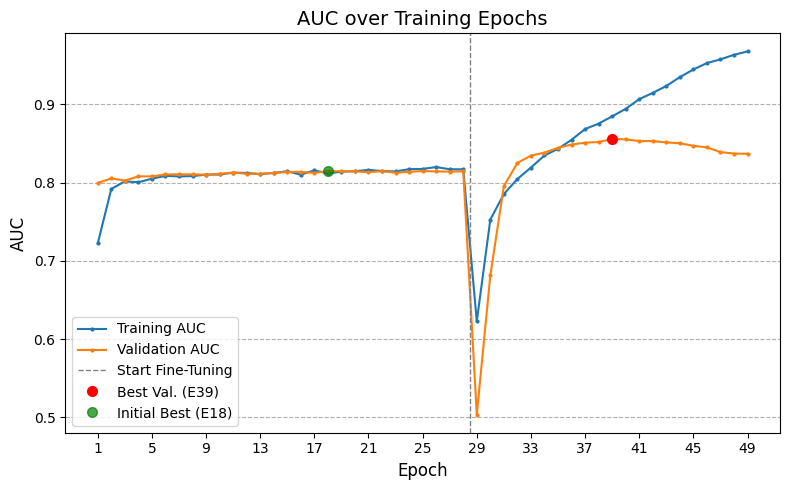

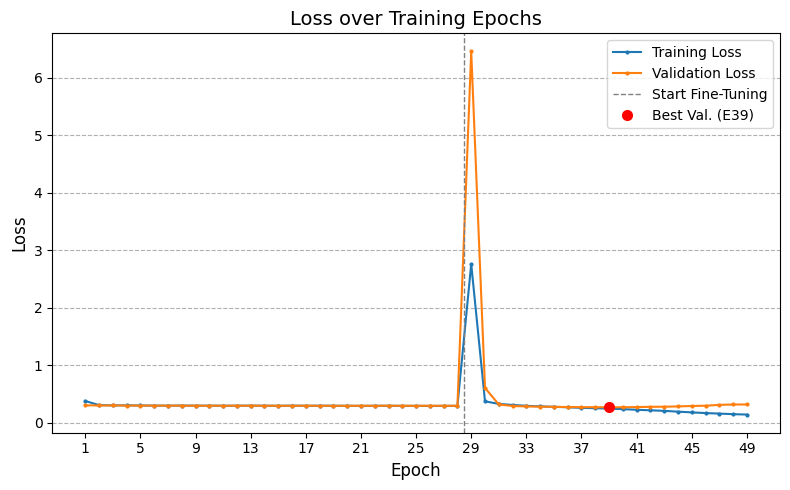


Code executed and plots displayed above.


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

log_text = """Starting training...
Epoch 1/30/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4330 - auc: 0.7223 - bin_acc: 0.8460 - loss: 0.3752
Epoch 1: val_auc improved from -inf to 0.79951, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.4332 - auc: 0.7225 - bin_acc: 0.8461 - loss: 0.3750 - val_accuracy: 0.5545 - val_auc: 0.7995 - val_bin_acc: 0.8859 - val_loss: 0.2995
Epoch 2/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5383 - auc: 0.7918 - bin_acc: 0.8850 - loss: 0.3032
Epoch 2: val_auc improved from 0.79951 to 0.80535, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.5384 - auc: 0.7918 - bin_acc: 0.8850 - loss: 0.3032 - val_accuracy: 0.5312 - val_auc: 0.8053 - val_bin_acc: 0.8860 - val_loss: 0.2968
Epoch 3/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5508 - auc: 0.8015 - bin_acc: 0.8858 - loss: 0.2983
Epoch 3: val_auc did not improve from 0.80535319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.5508 - auc: 0.8015 - bin_acc: 0.8858 - loss: 0.2983 - val_accuracy: 0.5689 - val_auc: 0.8026 - val_bin_acc: 0.8858 - val_loss: 0.2978
Epoch 4/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5485 - auc: 0.8004 - bin_acc: 0.8863 - loss: 0.2986
Epoch 4: val_auc improved from 0.80535 to 0.80787, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.5485 - auc: 0.8004 - bin_acc: 0.8863 - loss: 0.2986 - val_accuracy: 0.5673 - val_auc: 0.8079 - val_bin_acc: 0.8865 - val_loss: 0.2953
Epoch 5/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5616 - auc: 0.8049 - bin_acc: 0.8870 - loss: 0.2965
Epoch 5: val_auc improved from 0.80787 to 0.80793, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5616 - auc: 0.8049 - bin_acc: 0.8870 - loss: 0.2965 - val_accuracy: 0.5465 - val_auc: 0.8079 - val_bin_acc: 0.8870 - val_loss: 0.2954
Epoch 6/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5550 - auc: 0.8086 - bin_acc: 0.8868 - loss: 0.2947
Epoch 6: val_auc improved from 0.80793 to 0.81027, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.5550 - auc: 0.8086 - bin_acc: 0.8868 - loss: 0.2947 - val_accuracy: 0.5665 - val_auc: 0.8103 - val_bin_acc: 0.8869 - val_loss: 0.2938
Epoch 7/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5619 - auc: 0.8078 - bin_acc: 0.8870 - loss: 0.2945
Epoch 7: val_auc improved from 0.81027 to 0.81061, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5618 - auc: 0.8078 - bin_acc: 0.8870 - loss: 0.2945 - val_accuracy: 0.5497 - val_auc: 0.8106 - val_bin_acc: 0.8877 - val_loss: 0.2937
Epoch 8/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5343 - auc: 0.8083 - bin_acc: 0.8856 - loss: 0.2950
Epoch 8: val_auc did not improve from 0.81061319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5343 - auc: 0.8083 - bin_acc: 0.8856 - loss: 0.2950 - val_accuracy: 0.5713 - val_auc: 0.8104 - val_bin_acc: 0.8867 - val_loss: 0.2938
Epoch 9/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5507 - auc: 0.8101 - bin_acc: 0.8868 - loss: 0.2937
Epoch 9: val_auc did not improve from 0.81061319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5507 - auc: 0.8101 - bin_acc: 0.8868 - loss: 0.2937 - val_accuracy: 0.5673 - val_auc: 0.8101 - val_bin_acc: 0.8877 - val_loss: 0.2934
Epoch 10/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5555 - auc: 0.8103 - bin_acc: 0.8870 - loss: 0.2936
Epoch 10: val_auc improved from 0.81061 to 0.81122, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.5555 - auc: 0.8103 - bin_acc: 0.8870 - loss: 0.2936 - val_accuracy: 0.5665 - val_auc: 0.8112 - val_bin_acc: 0.8872 - val_loss: 0.2930
Epoch 11/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5448 - auc: 0.8127 - bin_acc: 0.8865 - loss: 0.2926
Epoch 11: val_auc improved from 0.81122 to 0.81279, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.5448 - auc: 0.8127 - bin_acc: 0.8865 - loss: 0.2926 - val_accuracy: 0.5585 - val_auc: 0.8128 - val_bin_acc: 0.8873 - val_loss: 0.2924
Epoch 12/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5471 - auc: 0.8122 - bin_acc: 0.8867 - loss: 0.2929
Epoch 12: val_auc did not improve from 0.81279319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5471 - auc: 0.8122 - bin_acc: 0.8867 - loss: 0.2929 - val_accuracy: 0.5681 - val_auc: 0.8112 - val_bin_acc: 0.8871 - val_loss: 0.2931
Epoch 13/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5382 - auc: 0.8109 - bin_acc: 0.8859 - loss: 0.2938
Epoch 13: val_auc did not improve from 0.81279319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5382 - auc: 0.8109 - bin_acc: 0.8859 - loss: 0.2938 - val_accuracy: 0.5593 - val_auc: 0.8110 - val_bin_acc: 0.8880 - val_loss: 0.2932
Epoch 14/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5482 - auc: 0.8123 - bin_acc: 0.8868 - loss: 0.2927
Epoch 14: val_auc did not improve from 0.81279319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5482 - auc: 0.8123 - bin_acc: 0.8868 - loss: 0.2927 - val_accuracy: 0.5633 - val_auc: 0.8123 - val_bin_acc: 0.8875 - val_loss: 0.2925
Epoch 15/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5445 - auc: 0.8144 - bin_acc: 0.8870 - loss: 0.2915
Epoch 15: val_auc improved from 0.81279 to 0.81362, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.5445 - auc: 0.8144 - bin_acc: 0.8870 - loss: 0.2915 - val_accuracy: 0.5705 - val_auc: 0.8136 - val_bin_acc: 0.8874 - val_loss: 0.2920
Epoch 16/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5342 - auc: 0.8101 - bin_acc: 0.8861 - loss: 0.2938
Epoch 16: val_auc did not improve from 0.81362319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5342 - auc: 0.8101 - bin_acc: 0.8861 - loss: 0.2938 - val_accuracy: 0.5633 - val_auc: 0.8136 - val_bin_acc: 0.8875 - val_loss: 0.2920
Epoch 17/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5347 - auc: 0.8156 - bin_acc: 0.8861 - loss: 0.2915
Epoch 17: val_auc did not improve from 0.81362319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5347 - auc: 0.8156 - bin_acc: 0.8861 - loss: 0.2915 - val_accuracy: 0.5665 - val_auc: 0.8123 - val_bin_acc: 0.8866 - val_loss: 0.2934
Epoch 18/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5419 - auc: 0.8117 - bin_acc: 0.8865 - loss: 0.2930
Epoch 18: val_auc improved from 0.81362 to 0.81473, saving model to best_genre_model.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.5419 - auc: 0.8117 - bin_acc: 0.8865 - loss: 0.2930 - val_accuracy: 0.5705 - val_auc: 0.8147 - val_bin_acc: 0.8872 - val_loss: 0.2917
Epoch 19/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5339 - auc: 0.8139 - bin_acc: 0.8865 - loss: 0.2919
Epoch 19: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5339 - auc: 0.8139 - bin_acc: 0.8865 - loss: 0.2919 - val_accuracy: 0.5481 - val_auc: 0.8144 - val_bin_acc: 0.8882 - val_loss: 0.2916
Epoch 20/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5372 - auc: 0.8145 - bin_acc: 0.8867 - loss: 0.2914
Epoch 20: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5372 - auc: 0.8145 - bin_acc: 0.8867 - loss: 0.2914 - val_accuracy: 0.5521 - val_auc: 0.8143 - val_bin_acc: 0.8878 - val_loss: 0.2916
Epoch 21/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5578 - auc: 0.8162 - bin_acc: 0.8879 - loss: 0.2902
Epoch 21: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.5577 - auc: 0.8162 - bin_acc: 0.8879 - loss: 0.2902 - val_accuracy: 0.5617 - val_auc: 0.8133 - val_bin_acc: 0.8884 - val_loss: 0.2919
Epoch 22/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5513 - auc: 0.8147 - bin_acc: 0.8872 - loss: 0.2913
Epoch 22: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.5512 - auc: 0.8147 - bin_acc: 0.8872 - loss: 0.2913 - val_accuracy: 0.5713 - val_auc: 0.8145 - val_bin_acc: 0.8876 - val_loss: 0.2916
Epoch 23/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5527 - auc: 0.8142 - bin_acc: 0.8874 - loss: 0.2914
Epoch 23: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.5527 - auc: 0.8142 - bin_acc: 0.8874 - loss: 0.2914 - val_accuracy: 0.5529 - val_auc: 0.8126 - val_bin_acc: 0.8880 - val_loss: 0.2929
Epoch 24/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5539 - auc: 0.8171 - bin_acc: 0.8875 - loss: 0.2901
Epoch 24: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.5539 - auc: 0.8171 - bin_acc: 0.8875 - loss: 0.2901 - val_accuracy: 0.5497 - val_auc: 0.8137 - val_bin_acc: 0.8885 - val_loss: 0.2919
Epoch 25/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5471 - auc: 0.8174 - bin_acc: 0.8875 - loss: 0.2901
Epoch 25: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.5470 - auc: 0.8174 - bin_acc: 0.8875 - loss: 0.2901 - val_accuracy: 0.5729 - val_auc: 0.8147 - val_bin_acc: 0.8876 - val_loss: 0.2914
Epoch 26/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5404 - auc: 0.8198 - bin_acc: 0.8866 - loss: 0.2890
Epoch 26: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5404 - auc: 0.8198 - bin_acc: 0.8866 - loss: 0.2890 - val_accuracy: 0.5681 - val_auc: 0.8143 - val_bin_acc: 0.8873 - val_loss: 0.2917
Epoch 27/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5453 - auc: 0.8170 - bin_acc: 0.8875 - loss: 0.2901
Epoch 27: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.5453 - auc: 0.8170 - bin_acc: 0.8875 - loss: 0.2901 - val_accuracy: 0.5673 - val_auc: 0.8139 - val_bin_acc: 0.8872 - val_loss: 0.2919
Epoch 28/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5375 - auc: 0.8169 - bin_acc: 0.8869 - loss: 0.2904
Epoch 28: val_auc did not improve from 0.81473319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.5375 - auc: 0.8169 - bin_acc: 0.8869 - loss: 0.2904 - val_accuracy: 0.5489 - val_auc: 0.8144 - val_bin_acc: 0.8881 - val_loss: 0.2916
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.

Training complete! Best weights saved to: best_genre_model.weights.h5Best weights from initial training (AUC: 0.8147) loaded successfully.

Base model layers set to trainable: True. All parameters (23M+) will now be optimized.

Starting fine-tuning...
Epoch 1/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3074 - auc: 0.6226 - bin_acc: 0.8749 - loss: 2.7570
Epoch 1: val_auc improved from -inf to 0.50345, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 167s 326ms/step - accuracy: 0.3076 - auc: 0.6227 - bin_acc: 0.8749 - loss: 2.7534 - val_accuracy: 0.5657 - val_auc: 0.5035 - val_bin_acc: 0.8800 - val_loss: 6.4563
Epoch 2/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4490 - auc: 0.7527 - bin_acc: 0.8797 - loss: 0.3684
Epoch 2: val_auc improved from 0.50345 to 0.68141, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.4490 - auc: 0.7527 - bin_acc: 0.8797 - loss: 0.3684 - val_accuracy: 0.5288 - val_auc: 0.6814 - val_bin_acc: 0.8831 - val_loss: 0.6025
Epoch 3/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4806 - auc: 0.7853 - bin_acc: 0.8833 - loss: 0.3251
Epoch 3: val_auc improved from 0.68141 to 0.79553, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 309ms/step - accuracy: 0.4806 - auc: 0.7853 - bin_acc: 0.8833 - loss: 0.3251 - val_accuracy: 0.5200 - val_auc: 0.7955 - val_bin_acc: 0.8909 - val_loss: 0.3150
Epoch 4/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4988 - auc: 0.8045 - bin_acc: 0.8865 - loss: 0.3055
Epoch 4: val_auc improved from 0.79553 to 0.82502, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.4988 - auc: 0.8045 - bin_acc: 0.8865 - loss: 0.3055 - val_accuracy: 0.5561 - val_auc: 0.8250 - val_bin_acc: 0.8934 - val_loss: 0.2884
Epoch 5/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5073 - auc: 0.8192 - bin_acc: 0.8890 - loss: 0.2915
Epoch 5: val_auc improved from 0.82502 to 0.83454, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 308ms/step - accuracy: 0.5073 - auc: 0.8192 - bin_acc: 0.8890 - loss: 0.2915 - val_accuracy: 0.5561 - val_auc: 0.8345 - val_bin_acc: 0.8932 - val_loss: 0.2799
Epoch 6/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5096 - auc: 0.8346 - bin_acc: 0.8920 - loss: 0.2802
Epoch 6: val_auc improved from 0.83454 to 0.83827, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.5096 - auc: 0.8346 - bin_acc: 0.8920 - loss: 0.2802 - val_accuracy: 0.5513 - val_auc: 0.8383 - val_bin_acc: 0.8942 - val_loss: 0.2769
Epoch 7/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5169 - auc: 0.8431 - bin_acc: 0.8931 - loss: 0.2741
Epoch 7: val_auc improved from 0.83827 to 0.84429, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 308ms/step - accuracy: 0.5169 - auc: 0.8431 - bin_acc: 0.8931 - loss: 0.2741 - val_accuracy: 0.5545 - val_auc: 0.8443 - val_bin_acc: 0.8944 - val_loss: 0.2729
Epoch 8/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5265 - auc: 0.8546 - bin_acc: 0.8973 - loss: 0.2652
Epoch 8: val_auc improved from 0.84429 to 0.84860, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.5265 - auc: 0.8546 - bin_acc: 0.8973 - loss: 0.2652 - val_accuracy: 0.5272 - val_auc: 0.8486 - val_bin_acc: 0.8953 - val_loss: 0.2698
Epoch 9/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5303 - auc: 0.8684 - bin_acc: 0.8996 - loss: 0.2554
Epoch 9: val_auc improved from 0.84860 to 0.85093, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 308ms/step - accuracy: 0.5303 - auc: 0.8684 - bin_acc: 0.8996 - loss: 0.2554 - val_accuracy: 0.5465 - val_auc: 0.8509 - val_bin_acc: 0.8961 - val_loss: 0.2676
Epoch 10/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5372 - auc: 0.8753 - bin_acc: 0.9022 - loss: 0.2496
Epoch 10: val_auc improved from 0.85093 to 0.85179, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 99s 310ms/step - accuracy: 0.5372 - auc: 0.8753 - bin_acc: 0.9022 - loss: 0.2496 - val_accuracy: 0.5433 - val_auc: 0.8518 - val_bin_acc: 0.8959 - val_loss: 0.2674
Epoch 11/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5383 - auc: 0.8846 - bin_acc: 0.9038 - loss: 0.2422
Epoch 11: val_auc improved from 0.85179 to 0.85569, saving model to best_genre_model_fine_tuned.weights.h5319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 308ms/step - accuracy: 0.5383 - auc: 0.8846 - bin_acc: 0.9038 - loss: 0.2422 - val_accuracy: 0.5425 - val_auc: 0.8557 - val_bin_acc: 0.8969 - val_loss: 0.2649
Epoch 12/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5389 - auc: 0.8942 - bin_acc: 0.9075 - loss: 0.2333
Epoch 12: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 305ms/step - accuracy: 0.5389 - auc: 0.8942 - bin_acc: 0.9075 - loss: 0.2333 - val_accuracy: 0.5449 - val_auc: 0.8552 - val_bin_acc: 0.8960 - val_loss: 0.2665
Epoch 13/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5490 - auc: 0.9066 - bin_acc: 0.9112 - loss: 0.2217
Epoch 13: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 305ms/step - accuracy: 0.5490 - auc: 0.9065 - bin_acc: 0.9112 - loss: 0.2218 - val_accuracy: 0.5401 - val_auc: 0.8530 - val_bin_acc: 0.8968 - val_loss: 0.2692
Epoch 14/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5610 - auc: 0.9146 - bin_acc: 0.9148 - loss: 0.2133
Epoch 14: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 304ms/step - accuracy: 0.5609 - auc: 0.9146 - bin_acc: 0.9148 - loss: 0.2133 - val_accuracy: 0.5361 - val_auc: 0.8530 - val_bin_acc: 0.8969 - val_loss: 0.2732
Epoch 15/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5578 - auc: 0.9234 - bin_acc: 0.9186 - loss: 0.2028
Epoch 15: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 305ms/step - accuracy: 0.5578 - auc: 0.9234 - bin_acc: 0.9186 - loss: 0.2028 - val_accuracy: 0.5232 - val_auc: 0.8513 - val_bin_acc: 0.8962 - val_loss: 0.2750
Epoch 16/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5582 - auc: 0.9347 - bin_acc: 0.9243 - loss: 0.1891
Epoch 16: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - accuracy: 0.5583 - auc: 0.9347 - bin_acc: 0.9243 - loss: 0.1891 - val_accuracy: 0.5040 - val_auc: 0.8502 - val_bin_acc: 0.8963 - val_loss: 0.2805
Epoch 17/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5667 - auc: 0.9445 - bin_acc: 0.9282 - loss: 0.1767
Epoch 17: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 98s 306ms/step - accuracy: 0.5667 - auc: 0.9445 - bin_acc: 0.9282 - loss: 0.1767 - val_accuracy: 0.5088 - val_auc: 0.8470 - val_bin_acc: 0.8950 - val_loss: 0.2880
Epoch 18/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5697 - auc: 0.9527 - bin_acc: 0.9337 - loss: 0.1645
Epoch 18: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - accuracy: 0.5696 - auc: 0.9527 - bin_acc: 0.9337 - loss: 0.1645 - val_accuracy: 0.4912 - val_auc: 0.8449 - val_bin_acc: 0.8962 - val_loss: 0.2927
Epoch 19/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5777 - auc: 0.9574 - bin_acc: 0.9379 - loss: 0.1557
Epoch 19: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - accuracy: 0.5777 - auc: 0.9574 - bin_acc: 0.9379 - loss: 0.1557 - val_accuracy: 0.5088 - val_auc: 0.8390 - val_bin_acc: 0.8948 - val_loss: 0.3072
Epoch 20/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5719 - auc: 0.9633 - bin_acc: 0.9419 - loss: 0.1454
Epoch 20: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 144s 310ms/step - accuracy: 0.5719 - auc: 0.9633 - bin_acc: 0.9419 - loss: 0.1454 - val_accuracy: 0.4864 - val_auc: 0.8370 - val_bin_acc: 0.8953 - val_loss: 0.3140
Epoch 21/30319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5766 - auc: 0.9675 - bin_acc: 0.9437 - loss: 0.1387
Epoch 21: val_auc did not improve from 0.85569319/319 ━━━━━━━━━━━━━━━━━━━━ 97s 304ms/step - accuracy: 0.5766 - auc: 0.9675 - bin_acc: 0.9437 - loss: 0.1387 - val_accuracy: 0.4760 - val_auc: 0.8368 - val_bin_acc: 0.8944 - val_loss: 0.3139
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.

Fine-tuning complete. Best fine-tuned weights loaded for final evaluation.
"""

# Split the log into initial training and fine-tuning sections
initial_training_log = log_text.split("Starting fine-tuning...")[0]
fine_tuning_log = log_text.split("Starting fine-tuning...")[-1].split("Fine-tuning complete.")[0]

# Regex to extract epoch, training AUC, training loss, validation AUC, and validation loss
# Pattern: Epoch (d+)/d+... - auc: ([\d\.]+) ... - loss: ([\d\.]+) ... - val_auc: ([\d\.]+) ... - val_loss: ([\d\.]+)
regex = r"Epoch\s+(\d+)/\d+.*?auc:\s+([\d\.]+).*?loss:\s+([\d\.]+).*?val_auc:\s+([\d\.]+).*?val_loss:\s+([\d\.]+)"

# --- Data Extraction Function ---
def extract_data(log, phase_name, start_overall_epoch=0):
    data = []
    matches = re.findall(regex, log, re.DOTALL)
    for match in matches:
        # Note: epoch_rel is the epoch number within its phase (1, 2, 3...)
        epoch_rel, train_auc, train_loss, val_auc, val_loss = map(float, match)
        epoch_overall = start_overall_epoch + epoch_rel
        data.append([epoch_overall, train_auc, train_loss, val_auc, val_loss, phase_name])
    return pd.DataFrame(data, columns=['Epoch', 'Train_AUC', 'Train_Loss', 'Val_AUC', 'Val_Loss', 'Phase'])

# Extract initial training data
df_initial = extract_data(initial_training_log, 'Initial Training')
start_overall_epoch = df_initial['Epoch'].max() if not df_initial.empty else 0

# Extract fine-tuning data
df_fine_tuning = extract_data(fine_tuning_log, 'Fine-Tuning', start_overall_epoch)

# Combine the DataFrames
df_combined = pd.concat([df_initial, df_fine_tuning], ignore_index=True)

# Find key points
best_finetune_auc_epoch = df_fine_tuning[df_fine_tuning['Val_AUC'] == df_fine_tuning['Val_AUC'].max()]['Epoch'].iloc[0]
best_initial_auc_epoch = df_initial[df_initial['Val_AUC'] == df_initial['Val_AUC'].max()]['Epoch'].iloc[0]

# --- Plotting Function (Minimal) ---
def plot_metric(df, metric_col, metric_name, best_epoch, best_initial_epoch):
    plt.figure(figsize=(8, 5))

    # Plot lines with simple markers
    plt.plot(df['Epoch'], df[f'Train_{metric_col}'], label=f'Training {metric_name}', marker='.', markersize=4, linestyle='-')
    plt.plot(df['Epoch'], df[f'Val_{metric_col}'], label=f'Validation {metric_name}', marker='.', markersize=4, linestyle='-')

    # Add vertical line for the start of fine-tuning
    start_finetuning_line = start_overall_epoch + 0.5
    plt.axvline(x=start_finetuning_line, color='grey', linestyle='--', linewidth=1, label='Start Fine-Tuning')

    # Highlight the final best point (Fine-Tuning best AUC/Loss)
    best_value = df[df['Epoch'] == best_epoch][f'Val_{metric_col}'].iloc[0]
    plt.plot(best_epoch, best_value, 'ro', markersize=7, label=f'Best Val. (E{int(best_epoch)})')

    # Optionally highlight the best initial point for the AUC plot
    if metric_name == 'AUC':
        best_initial_value = df[df['Epoch'] == best_initial_epoch][f'Val_{metric_col}'].iloc[0]
        plt.plot(best_initial_epoch, best_initial_value, 'go', markersize=7, alpha=0.7, label=f'Initial Best (E{int(best_initial_epoch)})')


    plt.title(f'{metric_name} over Training Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend(loc='lower left' if metric_name == 'AUC' else 'upper right', fontsize=10)
    plt.grid(axis='y', linestyle='--')
    plt.xticks(df['Epoch'][::4].astype(int)) # Show every 4th epoch
    plt.tight_layout()
    plt.show()

# --- Generate Graphs ---
# 1. AUC Plot
plot_metric(df_combined, 'AUC', 'AUC', best_finetune_auc_epoch, best_initial_auc_epoch)

# 2. Loss Plot
# Note: Use the epoch from the best AUC for the loss plot as well
plot_metric(df_combined, 'Loss', 'Loss', best_finetune_auc_epoch, best_initial_auc_epoch)

print("\nCode executed and plots displayed above.")